# Временные ряды 3. 

# Домашнее задание

# Моделируем временные ряды по ARIMA

# Задание

1. Прочитайте базу my_PJME_MW.csv и сделайте ее перрасчет (ресемплинг) в представление по 1 месяцу.

2. Подберите параметры модели SARIMAX для этого ряда.

3. Сделайте вывод о том, как изменилась модель по сравнению с недельной.

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd 
import seaborn as sns


from sklearn.metrics import mean_squared_error
import os

Загрузим файл с данными и посмотрим на таблицу их организующую.

In [3]:
Path_Energy = 'my_PJME_MW.csv'
data = pd.read_csv(Path_Energy, index_col=[0], parse_dates=[0])

data.head()

,Time,PJME_MW,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,hour,is_holiday,is_prev_holiday,is_next_holiday
Date,,,,,,,,,,,,,
2002-01-01,01:00:00,30393.0,2002,1,1,1,1,1,1,1,1,0,0
2002-01-01,02:00:00,29265.0,2002,1,1,1,1,1,1,2,1,0,0
2002-01-01,03:00:00,28357.0,2002,1,1,1,1,1,1,3,1,0,0
2002-01-01,04:00:00,27899.0,2002,1,1,1,1,1,1,4,1,0,0
2002-01-01,05:00:00,28057.0,2002,1,1,1,1,1,1,5,1,0,0


Описательная статистика практически не изменилась после обработки пропусков, сортировки и удаления дублей.

In [4]:
data.describe()

,PJME_MW,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,hour,is_holiday,is_prev_holiday,is_next_holiday
count,145374.000000,145374.000000,145374.000000,145374.000000,145374.000000,145374.000000,145374.000000,145374.000000,145374.000000,145374.000000,145374.000000,145374.000000
mean,32079.773047,2009.801340,6.435979,15.722681,2.481241,180.459835,26.218643,2.999168,11.501101,0.027233,0.027075,0.027240
std,6464.167501,4.791885,3.438982,8.801258,1.114448,105.138073,15.019836,1.999572,6.921927,0.162763,0.162303,0.162783
min,14544.000000,2002.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,27573.000000,2006.000000,3.000000,8.000000,1.000000,90.000000,13.000000,1.000000,6.000000,0.000000,0.000000,0.000000
50%,31421.000000,2010.000000,6.000000,16.000000,2.000000,179.000000,26.000000,3.000000,12.000000,0.000000,0.000000,0.000000
75%,35648.750000,2014.000000,9.000000,23.000000,3.000000,271.000000,39.000000,5.000000,18.000000,0.000000,0.000000,0.000000
max,62009.000000,2018.000000,12.000000,31.000000,4.000000,366.000000,53.000000,6.000000,23.000000,1.000000,1.000000,1.000000


Общий вид изменения ключевого свойства ряда приведен на рис.1.

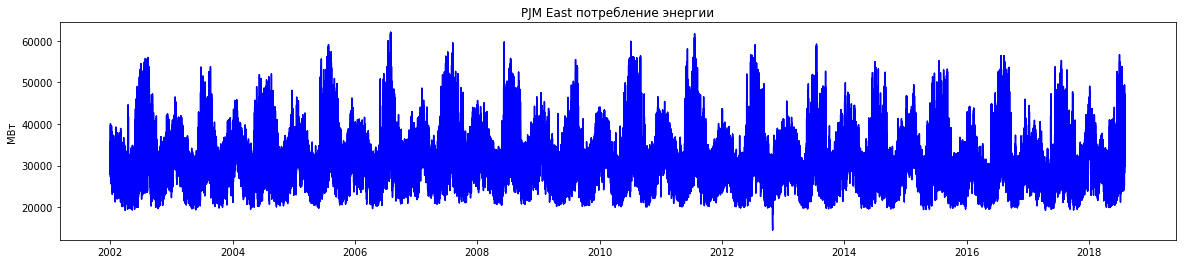

In [5]:
plt.figure(figsize =(20,4))
plt.plot( data.index, data['PJME_MW'], 'b' )
plt.title('PJM East потребление энергии' )
plt.ylabel ( 'МВт' )
plt.show()

Рис.1. Потребление энергии

### Методы анализа рядов

При построении моделей временных обычно говорят о следующих типах моделей:
- статистические, где зависимость будущего значения от прошлого задается в виде некоторого уравнения, а их делят на регрессионные модели (линейная регрессия, нелинейная регрессия), авторегрессионные модели (ARIMAX), модель экспоненциального сглаживания и т.д. Эта форма описания ряда содержит представление о формуле с параметрами, которые хорошо обходят точки соответствующие прошлому и, наверное, будут хорошо описывать будущее. 
- структурные модели, где зависимость будущего значения от прошлого задается в виде некоторой структуры и правил перехода по ней. К ним относят нейросетевые модели, модели на базе цепей Маркова, модели на базе классификационно-регрессионных деревьев и т.д.
- спектральные модели, которые основаны на определении временного ряда как совокупности простых процессов разной частоты.

Таким образом, возвращаясь к объектам реального мира для статистических моделей, если наш кот бегает за игрушкой и нам известна масса и размер котенка, а так же на основании предшествующих измерений нам удалось оценить корреляцию возраста, размера и массы котенка с его скоростью и маневренностью, то мы сможем предсказать, как быстро будет бегать питомец в будущем.  
С другой стороны модели на основе методов обучения, предполагают, что связь доступных для измерения свойств объекта или предшествующих значений ряда можно получить, если взять достаточно сложную функцию с параметрами и адаптировать(обучить) эти параметры опираясь на известные примеры. Близкие идеи реализует и спектральная модель описания явлений, т.к. ее задача состоит в подборе(вычислении) амплитуд простых процессов, из которых будем складывать описание прошлого.

Все подходы к моделированию рядов объединяет предположение, что будущее в некоторой степени зависит (и повторяет) прошлое. 

Перейдем к рассмотрению способов описания рядов на формальном уровне. По форме можно выделить две основных модели :
- аддитивная :  y(y) = X_trend(t) + X_cicle(t) + e(t)
- мультипликативная :  y(y) = X_trend(t) X_cicle(t) e(t)

Здесь y(y) - изменение значений ряда по времени, X_trend(t) - трендовая составляющая, X_cicle(t) - циклическая с оставляющая и случайная част e(t) ряда.
Разница между ними состоит в способе учета факторов влияющих на общее решение.

Рассмотрим вариант решения задачи описания временного ряда в форме модели ARIMA (статистическая форма анализа ряда) на базе пакета statsmodels http://www.statsmodels.org/dev/tsa.html.

In [6]:
#импорт модулей для формирования модели
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA

ARMA - Авторегрессионная модель скользящего среднего. В области анализа временных рядов модель авторегрессии (autoregressive, AR) и модель скользящего среднего (moving average, MA) является сравнительно простой и оперирует 2-мя параметрами: глубиной регрессии - р и длиной скользящего среднего - q. Чем больше q - тем больше сглаживание ряда (для нефти и Потребления энергии мы из примерно определили в процессе ресемплинга на разные интервалы).

ARIMA - Интегрированная Авторегрессионная модель скользящего среднего, построена для ряда первых разностей. Определяется на 3-х параметрах : p — порядок компоненты AR, d — порядок интегрированного ряда, q — порядок компонеты MA.


In [27]:
data_d = data.copy().resample('D').mean()
data_m = data.resample('M').mean()
data_w = data.resample('W').mean()
data_Y = data.resample('3M').mean()

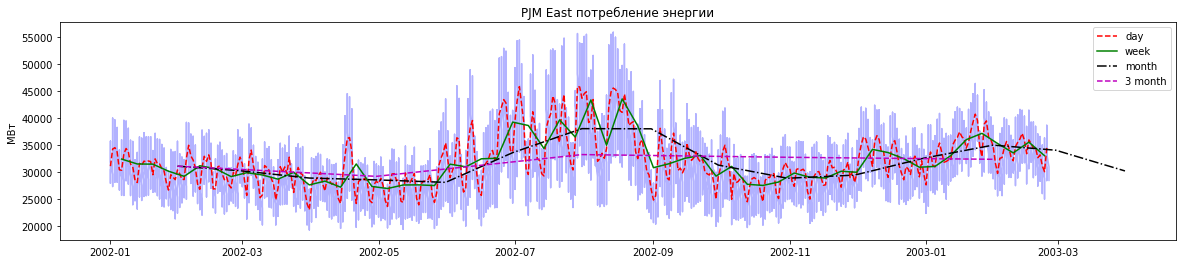

In [28]:
plt.figure(figsize =(20,4))
plt.plot( data.index[:5*24*7*4*3], data['PJME_MW'].values[:5*24*7*4*3], 'b',alpha =0.3 )
plt.plot( data_d.index[:5*7*4*3], data_d['PJME_MW'].values[:5*7*4*3], '--r',label='day' )
plt.plot( data_w.index[:5*4*3], data_w['PJME_MW'].values[:5*4*3], 'g',label='week'  )
plt.plot( data_m.index[:5*3], data_m['PJME_MW'].values[:5*3], '-.k',label='month'  )
plt.plot( data_Y.index[:5], data_Y['PJME_MW'].values[:5], '--m',label='3 month'  )
plt.title('PJM East потребление энергии' )
plt.ylabel ( 'МВт' )
plt.legend()
plt.show()

Но сначала посмотрим , что можно увидеть для исходной модели (работает очень долго)

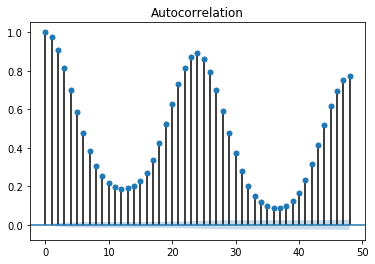

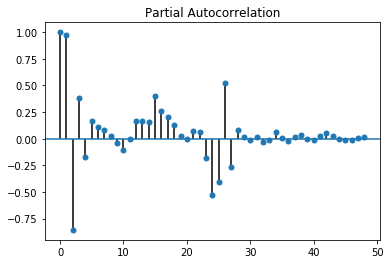

In [11]:
#plt.figure(figsize=(20,8))
#plt.subplot(2,1,1)
sm.graphics.tsa.plot_acf(data['PJME_MW'].values, lags=24*2)
plt.show()

#plt.subplot(2,1,2)
sm.graphics.tsa.plot_pacf(data['PJME_MW'].values, lags=24*2)
plt.show()

Получили оценку автокорреляции часовой модели по иcходному ряду и его первым разностям. Для этой модели можно увидеть значительную автокорреляцию с лагом 24 часа(никто и не сомневался см.рис. Autocorrelation) и значительную корреляцию остатков по первым трем лагам (Partial Autocorrelation) с падением, но не нулевой корреляцией для лагов до 24 часов. Первый график говорит о параметре части MA(24) - т.е следует рассматривать ресемплинг модели (поскольку авторегрессия 24) на дневные модели. По второму графику можно сказать, что есть нестационарность и необходимо ее отделить от нашего ряда. Мы помним, что ADF нам эту нестационарность уже диагностировал (временные ряды 2). Посмотрим ресемплинг на дневные данные, т.е. сгладим наш ряд по упрощенной схеме.

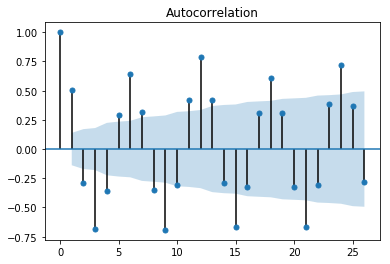

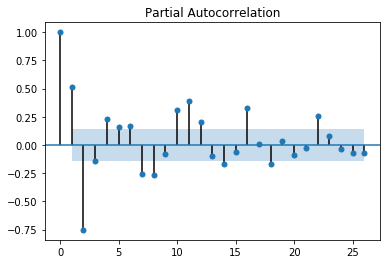

In [12]:
sm.graphics.tsa.plot_acf(data_m['PJME_MW'].values, lags=26)
plt.show()
sm.graphics.tsa.plot_pacf(data_m['PJME_MW'].values, lags=26)
plt.show()

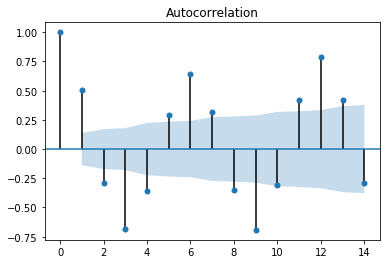

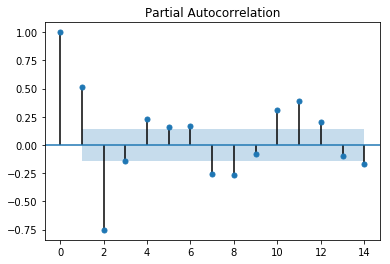

In [15]:
sm.graphics.tsa.plot_acf(data_m['PJME_MW'].values, lags=14)
plt.show()
sm.graphics.tsa.plot_pacf(data_m['PJME_MW'].values, lags=14)
plt.show()

In [17]:
import warnings

# Определим p, d и q 
q = 2
p = 1
d = 2
pdq = [p, d, q]
# определим комбинации сезонных параметров p, q и q, 
#будем работать с недельными данными, тогда сезонность это 26 недель
qs = 1
ps = 0
ds = 1
seasonal_pdq = [ps, ds, qs ,26] 


In [18]:
print('SARIMAX: p,d,q=',pdq,'   : ps,ds,qs, S=', seasonal_pdq)

SARIMAX: p,d,q= [1, 2, 2]    : ps,ds,qs, S= [0, 1, 1, 26]


In [19]:
#для построения модели используем все данные, кроме 12-х последних месяцев (это будет тестовый набор)
warnings.filterwarnings("ignore") # отключает предупреждения

mod = sm.tsa.statespace.SARIMAX(data_m['PJME_MW'].values[:-12],order=pdq,
                                seasonal_order=seasonal_pdq ,
                                enforce_stationarity= False ,
                                enforce_invertibility=False)
results = mod.fit()
print('SARIMAX{}x{} - AIC:{}'.format(pdq, seasonal_pdq, results.aic))


SARIMAX[1, 2, 2]x[0, 1, 1, 26] - AIC:2549.7081486880925


In [20]:
print(results.summary().tables[0],results.summary().tables[1])

                                 Statespace Model Results                                 
Dep. Variable:                                  y   No. Observations:                  188
Model:             SARIMAX(1, 2, 2)x(0, 1, 1, 26)   Log Likelihood               -1269.854
Date:                            Wed, 22 Jan 2020   AIC                           2549.708
Time:                                    15:49:19   BIC                           2564.084
Sample:                                         0   HQIC                          2555.550
                                            - 188                                         
Covariance Type:                              opg                                         
========================================================================================== ==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
-----------------------

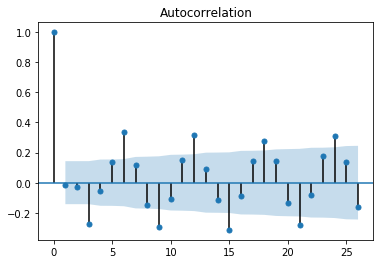

In [21]:
sm.graphics.tsa.plot_acf(results.resid, lags=26)
plt.show()

Оценим близости распределений остатков модели к нормальному закону используя визуализацию plot_diagnostics: 
- левый верхний график - остатки ряда 
- правый верхний - гистограмма для остатков ряда
- левый нижний - упорядоченное распределение остатков (квантильное)
- правый нижний - коррелограмма остатков

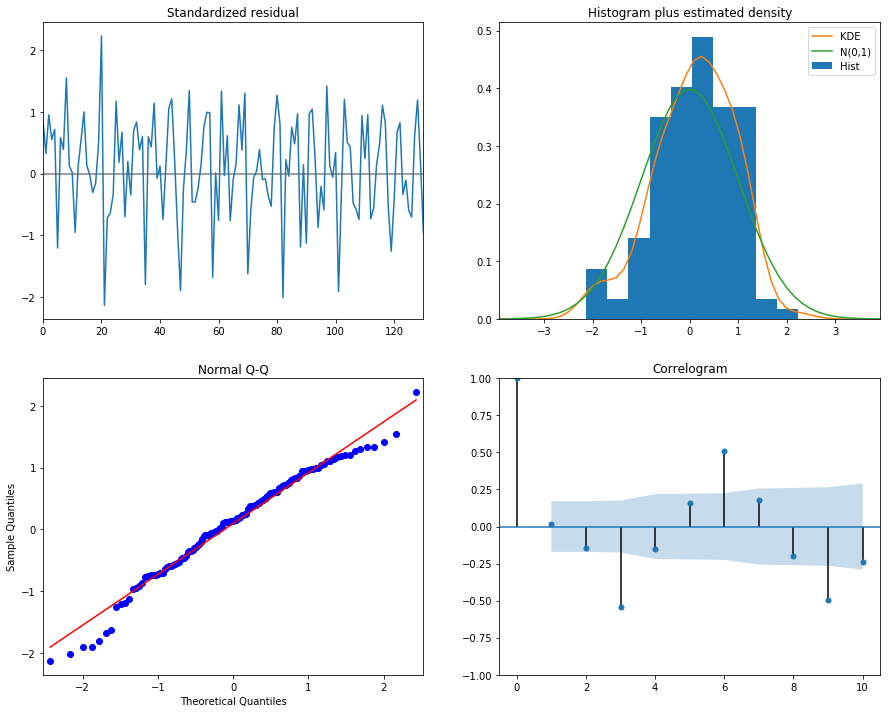

In [18]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

В этом случае диагностика показала, что остатки модели правильно распределяются:
- estimated density на верхнем-правом графике красная линия KDE находится близко к линии N (0,1) (где N (0,1) является стандартным обозначением нормального распределения со средним 0 и стандартным отклонением 1) . Очевидно, что остатки нормально распределены.
- График q-q в левом нижнем углу показывает, что упорядоченное распределение остатков (синие точки) следует линейному тренду выборок, взятых из стандартного распределения N (0, 1). Опять же, это признак того, что остатки нормально распределены.
- Остатки с течением времени (верхний левый график) не показывают явной сезонности и кажутся белыми шумами. Это подтверждается графиком автокорреляции (внизу справа), который показывает, что остатки временных рядов имеют низкую корреляцию с запаздывающими данными.

Эти графики позволяют сделать вывод о том, что выбранная модель (удовлетворительно) подходит для анализа и прогнозирования данных временных рядов.

Подобрать параметры модели можно используя сеточный выбор как это сделано для ряда "Потребление энергии" ниже (работает долго!):

- На основании анализа выбираем диапазон изменения параметров сезонности и остатка ряда (для этой модели берем [0,3]).
    
- задаем длину сезона (здесь 26 недель - зимой греем, летом кондиционируем и расход энергии примерно одинаковый)
    
- Запускаем генерацию сетки с использованием модуля itertools (itertools.product(p, d, q) - сгенерит декартово множество по p,d,q диапазонам) и задаем полный список вариантов.
    
- Запускаем генерацию SARIMAX - с параметрами и возвращаем AIC.
    
- Лучшее значение параметров (при минимальной оценке AIC) используем для настройки финальной модели.

In [22]:
import itertools

# Определим p, d и q в диапазоне 0-3
p = d = q = range(0, 3)
# зададим сетку p, q и q
pdq = list(itertools.product(p, d, q))
# зададим сезонность p, q и q
seasonal_pdq = [(x[0], x[1], x[2], 26) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 26)
SARIMAX: (0, 0, 1) x (0, 0, 2, 26)
SARIMAX: (0, 0, 2) x (0, 1, 0, 26)
SARIMAX: (0, 0, 2) x (0, 1, 1, 26)


In [26]:
%%time
warnings.filterwarnings("ignore") # отключает предупреждения
lst_of_result = []
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(data_m['PJME_MW'].values[:-30],order=param,
                                    seasonal_order=param_seasonal ,
                                    enforce_stationarity=False,
                                    enforce_invertibility=False)

            results = mod.fit()
            print('ARIMA{}x{}3 - AIC:{}'.format(param, param_seasonal, results.aic))
            lst_of_result.append(results.aic)
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 26)3 - AIC:3992.5110075928433
ARIMA(0, 0, 0)x(0, 0, 1, 26)3 - AIC:3285.6570594543095
ARIMA(0, 0, 0)x(0, 0, 2, 26)3 - AIC:4286.570104339657
ARIMA(0, 0, 0)x(0, 1, 0, 26)3 - AIC:2879.425251103865
ARIMA(0, 0, 0)x(0, 1, 1, 26)3 - AIC:2339.951891125026
ARIMA(0, 0, 0)x(0, 2, 0, 26)3 - AIC:2484.2063266048976
ARIMA(0, 0, 0)x(0, 2, 1, 26)3 - AIC:1888.470905613366
ARIMA(0, 0, 0)x(1, 0, 0, 26)3 - AIC:2899.327202799901
ARIMA(0, 0, 0)x(1, 0, 1, 26)3 - AIC:2880.013506225608
ARIMA(0, 0, 0)x(1, 0, 2, 26)3 - AIC:4326.910798005244
ARIMA(0, 0, 0)x(1, 1, 0, 26)3 - AIC:2351.140285803429
ARIMA(0, 0, 0)x(1, 1, 1, 26)3 - AIC:2332.2154398894536
ARIMA(0, 0, 0)x(1, 2, 0, 26)3 - AIC:1927.0384944589032
ARIMA(0, 0, 0)x(1, 2, 1, 26)3 - AIC:1899.1945235986523
ARIMA(0, 0, 0)x(2, 0, 0, 26)3 - AIC:2352.194131000001
ARIMA(0, 0, 0)x(2, 0, 1, 26)3 - AIC:2353.0270237702057
ARIMA(0, 0, 0)x(2, 0, 2, 26)3 - AIC:2332.962515001515
ARIMA(0, 0, 0)x(2, 1, 0, 26)3 - AIC:1735.992525672167
ARIMA(0, 0, 0)x(2, 1,

ARIMA(0, 2, 1)x(0, 1, 1, 26)3 - AIC:2276.3840454882425
ARIMA(0, 2, 1)x(0, 2, 0, 26)3 - AIC:2448.1678347196384
ARIMA(0, 2, 1)x(0, 2, 1, 26)3 - AIC:1839.0817231444717
ARIMA(0, 2, 1)x(1, 0, 0, 26)3 - AIC:2723.890207829022
ARIMA(0, 2, 1)x(1, 0, 1, 26)3 - AIC:2679.0318894445236
ARIMA(0, 2, 1)x(1, 0, 2, 26)3 - AIC:3927.8561341461946
ARIMA(0, 2, 1)x(1, 1, 0, 26)3 - AIC:2334.7779507307932
ARIMA(0, 2, 1)x(1, 1, 1, 26)3 - AIC:2234.4533329249607
ARIMA(0, 2, 1)x(1, 2, 0, 26)3 - AIC:1897.9126586629677
ARIMA(0, 2, 1)x(1, 2, 1, 26)3 - AIC:1834.8872058327497
ARIMA(0, 2, 1)x(2, 0, 0, 26)3 - AIC:2211.558598772101
ARIMA(0, 2, 1)x(2, 0, 1, 26)3 - AIC:2206.7081267711737
ARIMA(0, 2, 1)x(2, 0, 2, 26)3 - AIC:4450.729925937744
ARIMA(0, 2, 1)x(2, 1, 0, 26)3 - AIC:1712.4361603287307
ARIMA(0, 2, 1)x(2, 1, 1, 26)3 - AIC:1713.937601522733
ARIMA(0, 2, 1)x(2, 2, 0, 26)3 - AIC:1328.4079788029358
ARIMA(0, 2, 1)x(2, 2, 1, 26)3 - AIC:1240.5366380893151
ARIMA(0, 2, 2)x(0, 0, 0, 26)3 - AIC:3164.6031750667794
ARIMA(0, 2, 2)

ARIMA(1, 1, 2)x(1, 0, 2, 26)3 - AIC:9680.78821410609
ARIMA(1, 1, 2)x(1, 1, 0, 26)3 - AIC:2259.59552050598
ARIMA(1, 1, 2)x(1, 1, 1, 26)3 - AIC:2179.4053774115373
ARIMA(1, 1, 2)x(1, 2, 0, 26)3 - AIC:1841.8649724357522
ARIMA(1, 1, 2)x(1, 2, 1, 26)3 - AIC:1728.6598200997955
ARIMA(1, 1, 2)x(2, 0, 0, 26)3 - AIC:2156.682614213287
ARIMA(1, 1, 2)x(2, 0, 1, 26)3 - AIC:2150.4462965338407
ARIMA(1, 1, 2)x(2, 0, 2, 26)3 - AIC:9062.71262734928
ARIMA(1, 1, 2)x(2, 1, 0, 26)3 - AIC:1693.2011759930972
ARIMA(1, 1, 2)x(2, 1, 1, 26)3 - AIC:1693.704663346072
ARIMA(1, 1, 2)x(2, 2, 0, 26)3 - AIC:1241.807237456761
ARIMA(1, 1, 2)x(2, 2, 1, 26)3 - AIC:1233.694511319549
ARIMA(1, 2, 0)x(0, 0, 0, 26)3 - AIC:3252.358901834961
ARIMA(1, 2, 0)x(0, 0, 1, 26)3 - AIC:2740.08761557263
ARIMA(1, 2, 0)x(0, 0, 2, 26)3 - AIC:4605.51641368334
ARIMA(1, 2, 0)x(0, 1, 0, 26)3 - AIC:2868.867842146618
ARIMA(1, 2, 0)x(0, 1, 1, 26)3 - AIC:2278.6429050293154
ARIMA(1, 2, 0)x(0, 2, 0, 26)3 - AIC:2472.153836508416
ARIMA(1, 2, 0)x(0, 2, 1, 26

ARIMA(2, 1, 0)x(2, 0, 1, 26)3 - AIC:2130.262216104135
ARIMA(2, 1, 0)x(2, 0, 2, 26)3 - AIC:4489.214407977575
ARIMA(2, 1, 0)x(2, 1, 0, 26)3 - AIC:1668.876736575742
ARIMA(2, 1, 0)x(2, 1, 1, 26)3 - AIC:1669.195126143102
ARIMA(2, 1, 0)x(2, 2, 0, 26)3 - AIC:1219.3478001449885
ARIMA(2, 1, 0)x(2, 2, 1, 26)3 - AIC:1206.8167834199032
ARIMA(2, 1, 1)x(0, 0, 0, 26)3 - AIC:3021.7387729036573
ARIMA(2, 1, 1)x(0, 0, 1, 26)3 - AIC:2556.5382004499497
ARIMA(2, 1, 1)x(0, 0, 2, 26)3 - AIC:nan
ARIMA(2, 1, 1)x(0, 1, 0, 26)3 - AIC:2668.273228162005
ARIMA(2, 1, 1)x(0, 1, 1, 26)3 - AIC:2143.0345687014146
ARIMA(2, 1, 1)x(0, 2, 0, 26)3 - AIC:2295.0107141799826
ARIMA(2, 1, 1)x(0, 2, 1, 26)3 - AIC:1729.386411834712
ARIMA(2, 1, 1)x(1, 0, 0, 26)3 - AIC:2556.8576190230315
ARIMA(2, 1, 1)x(1, 0, 1, 26)3 - AIC:2558.532896236554
ARIMA(2, 1, 1)x(1, 0, 2, 26)3 - AIC:9688.236193131512
ARIMA(2, 1, 1)x(1, 1, 0, 26)3 - AIC:2148.2052189546644
ARIMA(2, 1, 1)x(1, 1, 1, 26)3 - AIC:2139.7588285875468
ARIMA(2, 1, 1)x(1, 2, 0, 26)3 - A

In [24]:
min(lst_of_result) 

1206.8167834199032

Лучшие результаты на недельных данных параметры модели SARIMAX(2, 1, 0)x(2, 2, 1, 26)3 - AIC:1206.8167834199032 

In [23]:
#для построения модели используем все данные, кроме 3-х последних месяцев (это будет тестовый набор)
warnings.filterwarnings("ignore") # отключает предупреждения

mod = sm.tsa.statespace.SARIMAX(data_m['PJME_MW'].values[:-12],order=[2,1,0],
                                seasonal_order=[2,2,1,26] ,
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results_opt = mod.fit()
print('AIC:',results_opt.aic)


AIC: 1542.0485729305635


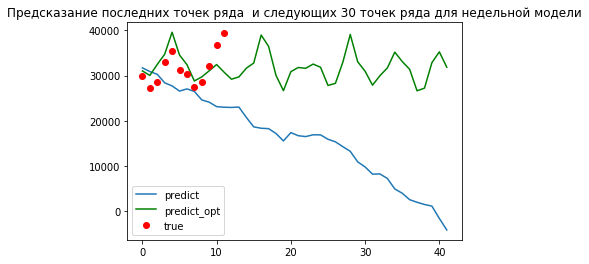

In [25]:
pred_dynamic = results.forecast(42)    #делаем предсказание на 3 точки от текущего конца ряда
pred_dynamic_opt = results_opt.forecast(42)

plt.plot(pred_dynamic, label='predict' )
plt.plot(pred_dynamic_opt,'g', label='predict_opt' )
#Отобразим истинный значения 
plt.plot(data_m['PJME_MW'].values[-12:],'or',label='true')
plt.title('Предсказание последних точек ряда  и следующих 30 точек ряда для недельной модели')
plt.legend()

plt.show()

Посмотрим на график недельной модели

<img src="week.png">

Видно, что предсказание новых точек тем слабее, чем дальше от последней известной точки ряда. Однако модель для предсказания по месяцам предсказывает лучше чем недельная.  Это связанно с тем, что в ряду по месяцам практически отсутствует цикличность и он более равномерен, чем ряд по неделям.

## Сохраниение модели

In [29]:
results_opt.save('rez_model.h5') # и обратно t_rez = sm.load('rez_model.h5')